# Introduction
This is my work on the [TAU Vehicle Type Recognition Competition](https://www.kaggle.com/c/vehicle/overview) Kaggle competition. In this notebook I want to show some concepts and techniques that are useful not only in image classification competitions, but also in other computer vision problems.
## Downloading the data and installing required packages
First, we need to download the dataset and organize it in such way that will be comfortable to work with. Because images in the dataset have different resolutions, I resized them to 512x512 pixels. The prepared dataset can be downloaded from Kaggle ([Kaggle link](https://www.kaggle.com/markseliaev/tut-images-512/)).
## Cloud environment
I trained my models on Google Colab, so in the notebook there are some colab-specific procedures that are always different in other environments.

# Installing requirements

In [3]:
from google.colab import drive
drive.mount('/gdrive')
# %cd /gdrive
!unzip -uq "/gdrive/My Drive/Datasets/images_512.zip" -d "/content/images"

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive


In [ ]:
!pip install albumentations > /dev/null


In [17]:
# Let's check how our filenames look like
!ls /content/images/test_resized_512 | head -n 5 # test images
!echo '---'
!ls /content/images/train_resized_512 | head -n 5 # train images

000000.jpg
000001.jpg
000002.jpg
000003.jpg
000004.jpg
---
000001_00_Bicycle.jpg
000001_02_Bus.jpg
000001_04_Truck.jpg
000001_08_Car.jpg
000001_11_Car.jpg


We can extract image class using regex pattern `(?<=_)(\w\D+)(?=.jpg)`

In [18]:
import os
import re
from tqdm import tqdm_notebook as tqdm
from PIL import Image
from time import time, strftime
from IPython.display import FileLink

import torch.nn as nn
import torch.optim as optim
import torch, torchvision
from torchvision import models
from torch.utils.data import Dataset, SubsetRandomSampler, WeightedRandomSampler, SequentialSampler
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import albumentations
%matplotlib inline


train_path = '/content/images/train_resized_512'
test_path = '../content/images/test_resized_512'
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

classes = ["Ambulance", "Barge", "Bicycle", "Boat", "Bus", "Car", "Cart", "Caterpillar",
           "Helicopter", "Limousine", "Motorcycle", "Segway",
           "Snowmobile", "Tank", "Taxi", "Truck", "Van"]
CLASSES_IDS = {x: i for i, x in enumerate(classes)} # "Van" -> 16 mapping
CLASSES_OF_IDS = {y: x for x, y in CLASSES_IDS.items()} # 16 -> "Van" mapping


print(f"There are {len(os.listdir(train_path))} train images; {len(os.listdir(test_path))} test images.")

There are 28046 train images; 7958 test images.


In [ ]:
import cv2
from albumentations import Compose, RandomCrop, Normalize, HorizontalFlip, ShiftScaleRotate, CenterCrop
from albumentations import (
    HorizontalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90,
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, RandomBrightnessContrast, IAAPiecewiseAffine,
    IAASharpen, IAAEmboss, Flip, OneOf, Compose
)
from albumentations.pytorch import ToTensor

# Initializing image augmentation

In [ ]:
def strong_aug(p=.5):
    return Compose([
        HorizontalFlip(p=.5),
        OneOf([
            IAAAdditiveGaussianNoise(),
            GaussNoise(),
        ], p=0.2),
        OneOf([
            MotionBlur(p=.2),
            MedianBlur(blur_limit=3, p=0.1),
            Blur(blur_limit=3, p=0.1),
        ], p=0.2),
        ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.15, rotate_limit=15, p=0.5),
        OneOf([
            CLAHE(clip_limit=2),
            IAASharpen(),
            IAAEmboss(),
            RandomBrightnessContrast(),            
        ], p=0.3),
        HueSaturationValue(p=0.3),
    ], p=p)

In [ ]:
class TrainDataset(Dataset):
    def __init__(self, path, transform=None):
        self.transform = transform
        self.path = path
        self.files = [x for x in os.listdir(path) if x.endswith('.jpg')]
        self.class_pattern = re.compile("(?<=_)(\w\D+)(?=.jpg)") 
        
    def __len__(self):
        return len(self.files)
    
    def get_class(self, index):
        img_name = self.files[index]
        y = CLASSES_IDS[re.findall(self.class_pattern, img_name)[0]]
        return y
    
    # rewriting for using albumentations
    def __getitem__(self, index):
        img_name = self.files[index]
        img = cv2.imread(os.path.join(self.path, img_name))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        y = CLASSES_IDS[re.findall(self.class_pattern, img_name)[0]]
        if self.transform:
            augmented = self.transform(image=img)
            img = augmented['image']
        return img, y, img_name
    
list_transforms = Compose([strong_aug(p=0.5), Normalize(), ToTensor()])  
train_dataset = TrainDataset(path=train_path, transform=list_transforms)
orig_dataset = TrainDataset(path=train_path, transform=strong_aug())

# Visualizing train images

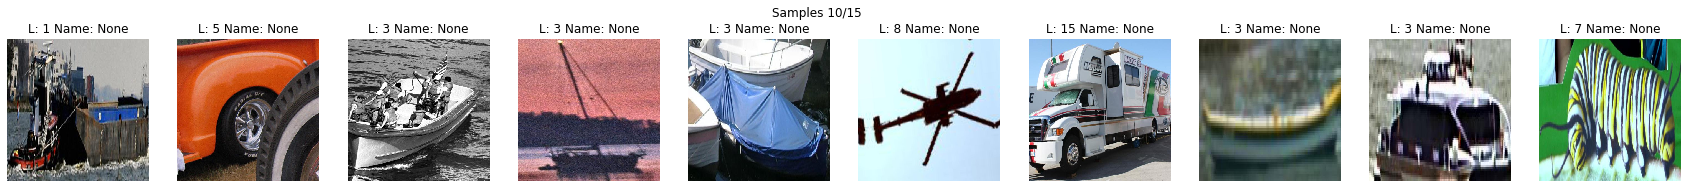

In [22]:
def visualize_samples(dataset, indices, title=None, count=10):
    # visualize random 10 samples
    plt.figure(figsize=(count*3,3))
    display_indices = indices[:count]
    if title:
        plt.suptitle("%s %s/%s" % (title, len(display_indices), len(indices)))        
    for i, index in enumerate(display_indices):    
        x, y, img_name = dataset[index]
        plt.subplot(1,count,i+1)
        plt.title(f"L: {y} Name: {None}")# plt.title("Label: %s, %s" % y, img_name)
        plt.imshow(x)
        plt.grid(False)
        plt.axis('off')

indices = np.random.choice(np.arange(len(train_dataset)), 15, replace=False)
visualize_samples(orig_dataset, indices, "Samples")

# Imbalanced dataset problem
Because classes are not uniformly distributed in the training dataset, we may use a weighted sampling approach. This means that we adjust probabilities of sampling a particular class by taking an inverse probability of that class. For some strange reason it didn't boost my score significantly, but nonetheless it's a valid approach that may help in any other situation with imbalanced distribution of classes.

In [ ]:
class ImbalancedDatasetSampler(torch.utils.data.sampler.Sampler):
    """Samples elements randomly from a given list of indices for imbalanced dataset
    Arguments:
        indices (list, optional): a list of indices
        num_samples (int, optional): number of samples to draw
    """

    def __init__(self, dataset, indices=None, num_samples=None):
                
        # if indices is not provided, 
        # all elements in the dataset will be considered
        self.indices = list(range(len(dataset))) \
            if indices is None else indices
            
        # if num_samples is not provided, 
        # draw `len(indices)` samples in each iteration
        self.num_samples = len(self.indices) \
            if num_samples is None else num_samples
            
        # distribution of classes in the dataset 
        label_to_count = {}
        for idx in tqdm(self.indices):
            label = self._get_label(dataset, idx)
            if label in label_to_count:
                label_to_count[label] += 1
            else:
                label_to_count[label] = 1
                
        # weight for each sample
        weights = [1.0 / label_to_count[self._get_label(dataset, idx)]
                   for idx in self.indices]
        self.weights = torch.DoubleTensor(weights)

    def _get_label(self, dataset, idx):
        dataset_type = type(dataset)
        if dataset_type is torchvision.datasets.MNIST:
            return dataset.train_labels[idx].item()
        elif dataset_type is torchvision.datasets.ImageFolder:
            return dataset.imgs[idx][1]
        else:
            return dataset.get_class(idx)
                
    def __iter__(self):
        return (self.indices[i] for i in torch.multinomial(
            self.weights, self.num_samples, replacement=True))

    def __len__(self):
        return self.num_samples

# Preparing training and validation PyTorch loaders

In [26]:
def get_trainval_loaders(dataset, batch_size=8, imbalanced=False):
    all_indices = np.arange(len(train_dataset))
    index_to_class = np.array([dataset.get_class(i) for i in tqdm(all_indices)])
    train_indices, val_indices = train_test_split(all_indices, test_size=0.2, shuffle=True, random_state=42, stratify=index_to_class)
    # creating samplers
    if imbalanced:
        train_sampler = ImbalancedDatasetSampler(dataset, train_indices)
        val_sampler = SubsetRandomSampler(val_indices) #ImbalancedDatasetSampler(dataset, val_indices)
    else:
        train_sampler = SubsetRandomSampler(train_indices)
        val_sampler = SubsetRandomSampler(val_indices)
    train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=train_sampler)
    val_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=val_sampler)
    return train_loader, val_loader


train_loader, val_loader = get_trainval_loaders(train_dataset, batch_size=32, imbalanced=True)    

# Functions for training

In [ ]:
def transfer_learning(model, l_type, optimizer, **kwargs):
    """
    l_type: 'one' or 'all', describes which layers weights to backprop.  
    optimizer: optimizer class from torch.optim
    """
    if l_type == 'last' or l_type == 'first_last':
        for param in model.parameters():
            param.requires_grad = False
    if not l_type.endswith('finetune'):
      num_features = model.fc.in_features
      model.fc = nn.Linear(num_features, len(CLASSES_IDS.keys()))
    else:
      model._classifier.requires_grad = True
      parameters = model._classifier.parameters()
    model = model.to(device)
    if l_type == 'last':
        model.fc.requires_grad = True
        parameters = model.fc.parameters()
    elif l_type == 'first_last':
        for param in model.conv1.parameters():
            param.requires_grad = True
        parameters = [{'params': model.conv1.parameters()}, {'params': model.fc.parameters()}]
    elif l_type == 'all':
        parameters = model.parameters()
    elif l_type == 'resnext50_lastconvs':
      for param in model.parameters():
        param.requires_grad = False
      for param in model.layer4.parameters():
        param.requires_grad = True
      model.fc.requires_grad = True
      parameters = [{'params': model.layer4.parameters()}, {'params': model.fc.parameters()}]
    
    optimizer = optimizer(parameters, **kwargs)
    return model, optimizer



def train_model(model, train_loader, val_loader, loss, optimizer, num_epochs, scheduler=None, model_name="noname"):    
    loss_history = []
    train_history = []
    val_history = []
    start_time = time()
    for epoch in range(1, num_epochs + 1):
        if epoch % 5 == 0:
            # torch.save(model.state_dict(), f'./model_{epoch}.pth')
            try:
              torch.save(model.state_dict(), f"/gdrive/My Drive/Datasets/model_{model_name}_{epoch}.pth")
            except:
              print('error')
        model.train() # Enter train mode
        loss_accum = 0
        correct_samples = 0
        total_samples = 0
        for i_step, (x, y, _) in enumerate(train_loader):
            x_gpu = x.to(device)
            y_gpu = y.to(device)
#             print(float(y.sum()) / float(y_gpu.shape[0]))
            prediction = model(x_gpu)    
            loss_value = loss(prediction, y_gpu)
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()
            
            preds = torch.argmax(prediction, 1)
            correct_samples += torch.sum(preds == y_gpu)
            total_samples += y.shape[0]
            loss_accum += loss_value

        ave_loss = loss_accum / i_step
        train_accuracy = float(correct_samples) / total_samples
        val_accuracy = compute_accuracy(model, val_loader)
        
        loss_history.append(float(ave_loss))
        train_history.append(train_accuracy)
        val_history.append(val_accuracy)
        
        if scheduler is not None:
            scheduler.step(loss_value)
        
        print("%d epoch Average loss: %f, Train accuracy: %f, Val Accuracy: %f --- %s" % (epoch, ave_loss, train_accuracy, val_accuracy, 
                                                                                    strftime("%H:%M:%S")))
    time_elapsed = time() - start_time    
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    return loss_history, train_history, val_history
        

def compute_accuracy(model, loader, confusion_matrix=False):
    """
    Computes accuracy on the dataset wrapped in a loader
    
    Returns: accuracy as a float value between 0 and 1
    """
    model.eval()
    correct_samples, total_samples = 0, 0
    if confusion_matrix:
      matrix = np.zeros((len(CLASSES_IDS), len(CLASSES_IDS)), dtype=np.int64)
    with torch.no_grad():
      for i_step, (x, y, _) in enumerate(loader, start=1):
          x_gpu, y_gpu = x.to(device), y.to(device)
          prediction = model(x_gpu)
          preds = torch.argmax(prediction, 1)
          correct_samples += torch.sum(preds == y_gpu)
          total_samples += y.shape[0]
          if confusion_matrix:
            for ground_truth, pred in zip(y_gpu, preds):
              matrix[ground_truth.item(), pred.item()] += 1
        
    if confusion_matrix:
      return float(correct_samples) / total_samples, matrix
    return float(correct_samples) / total_samples

In [28]:
model = torch.hub.load('pytorch/vision:v0.4.2', 'resnext50_32x4d', pretrained=True)

Downloading: "https://github.com/pytorch/vision/archive/v0.4.2.zip" to /root/.cache/torch/hub/v0.4.2.zip
Downloading: "https://download.pytorch.org/models/resnext50_32x4d-7cdf4587.pth" to /root/.cache/torch/checkpoints/resnext50_32x4d-7cdf4587.pth
100%|██████████| 95.8M/95.8M [00:05<00:00, 18.7MB/s]


In [ ]:
loss = nn.CrossEntropyLoss()
model, optimizer = transfer_learning(model, 'last', optim.SGD, lr=1e-2, weight_decay=0.001, momentum=0.9)
# model.load_state_dict(torch.load("/gdrive/My Drive/Datasets/Models/087_resnext50_withtta.pth")); model.eval();
print("Model configured!")
plateau_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, verbose=True, patience=2, threshold=1e-4, min_lr=0.00005)
print(f"Training started at {strftime('%H:%M:%S')}")
loss_history, train_history, val_history = train_model(model, train_loader, val_loader, loss, optimizer, 10, plateau_scheduler)

Model configured!
Training started at 21:26:09
1 epoch Average loss: 0.960389, Train accuracy: 0.698253, Val Accuracy: 0.658763 --- 21:36:51
2 epoch Average loss: 0.687689, Train accuracy: 0.781066, Val Accuracy: 0.723658 --- 21:47:36


# Making predictions on test dataset with TTA
TTA (test-time augmentation) – an approach for predicting test classes from differently augmented images. This approach consists of 2 steps:
1. Applying different augmentations to the same image
2. Taking the average from classes probabilities

In [ ]:
class TestDataset(Dataset):
    def __init__(self, path, transform=None):
        self.transform = transform
        self.path = path
        self.files = os.listdir(path)
        
    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, index):
        img_name = self.files[index]
        img_id = int(img_name.split('.')[0])
        img = Image.open(os.path.join(self.path, img_name))
        if self.transform:
            img = self.transform(img)
        return img, img_id


test_dataset = TestDataset(test_path, transform=transforms.Compose([
                           transforms.Lambda(lambda image: torch.stack([
                               transforms.ToTensor()(transforms.RandomHorizontalFlip(p=1)(image)),
                               transforms.ToTensor()(transforms.RandomRotation(15)(image)),
                               transforms.ToTensor()(image)
                           ])),
                           transforms.Lambda(
                           lambda images: torch.stack([transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])(image) for image in images]))
                           # Use mean and std for pretrained models
                           # https://pytorch.org/docs/stable/torchvision/models.html
#                            transforms.Normalize(mean=[0.485, 0.456, 0.406],
#                                  std=[0.229, 0.224, 0.225]),
                       ]))

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=8)


model.eval()
res = []
for img, img_id in tqdm(test_loader):
    with torch.no_grad():
        img = img.to(device)
        batch_size, n_crops, c, h, w = img.size()
        data = img.view(-1, c, h, w)
        output = model(data)
        output = output.view(batch_size, n_crops, -1).mean(1) # taking the average
        preds = torch.argmax(output, 1)
        for id_img, pred in zip(img_id, preds):
            res.append((id_img.item(), CLASSES_OF_IDS[pred.item()]))

import csv
with open('subm.csv', 'w') as submissionFile:
    writer = csv.writer(submissionFile)
    writer.writerow(['Id', 'Category'])
    writer.writerows(sorted(res, key=lambda x: x[0]))